In [1]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
class one_weight_linear_model():
    def __init__(self, method='relax', eps=1, theta=1, steps_to_exclude=20, part_to_exclude=0.05):
        self.w = None
        self.method = method
        self.part_to_exclude = part_to_exclude
        self.steps_to_exclude = steps_to_exclude
        self.eps = eps
        self.theta = theta
        self.D = None
        self.N = None
        
    def prepare_data(self, X, y):
        X = np.array(X)
        self.N = X.shape[0]
        X = np.concatenate((X, np.ones([self.N, 1])), axis=1)
        self.D = X.shape[1]
        self.w = np.random.normal(0, 2. / self.D, self.D)
        X = np.apply_along_axis(lambda a: a * (-1) ** (y + 1), 0, X)
        return X
    
    def calc_relax_dw(self, X):
        negatives = X[X.dot(self.w) <= self.eps]
        scalar_mults = np.abs(negatives.dot(self.w))
        dw = np.sum(np.apply_along_axis(lambda a: a * scalar_mults, 0, negatives), axis=0)
        if np.any(np.abs(dw) > 1e-10):
            dw *= np.sum(scalar_mults ** 2) / np.sum(dw ** 2)
        else:
            dw *= np.sum(scalar_mults ** 2) / 1e-15
        return dw
    
    def exclude_most_often_unfulfilled(self, X, unfulfilled):
        for i in range(max(1, int(self.N * self.part_to_exclude))):
            num_to_del = np.argmax(unfulfilled)
            X = np.delete(X, num_to_del, 0)
            unfulfilled = np.delete(unfulfilled, num_to_del, 0)
        return X, unfulfilled
    
    def fit_using_relaxation(self, X, y):
        X = self.prepare_data(X, y)
        unfulfilled = np.zeros(self.N)
        step_number = 0
        while np.any(X.dot(self.w) < self.eps) and step_number < 500:
            dw = self.calc_relax_dw(X)
            self.w += self.theta * dw
            unfulfilled += X.dot(self.w) < self.eps
            step_number += 1
            if step_number % self.steps_to_exclude == 0:
                X, unfulfilled = self.exclude_most_often_unfulfilled(X, unfulfilled)
                
    def prepare_for_linprog(self, X, y):
        X = self.prepare_data(X, y)
        X = np.concatenate((- X, np.ones([self.N, 1])), axis=1)
        c = np.concatenate([np.zeros(self.D), [-1]])
        bounds = [[None, None] for i in np.arange(self.D + 1)]
        bounds[-1][1] = 1
        return X, c, bounds
                
    def exclude_with_largest_angles(self, X, res):
        unfulfilled = X[:, :-1].dot(res[:-1]) <= 0
        sumed = np.sum(X[unfulfilled, :-1], axis=0)
        cosines = np.ones(X.shape[0])
        for j in np.arange(len(unfulfilled)):
            if not unfulfilled[j]:
                continue
            rest_of_sum = sumed - X[j, :-1]
            cosines[j] = X[j, :-1].dot(rest_of_sum) / \
            rest_of_sum.dot(rest_of_sum) / X[j, :-1].dot(X[j, :-1])
        to_exclude = []
        for i in np.arange(max(1, self.part_to_exclude * self.N)):
            argmin = np.argmin(cosines)
            cosines[argmin] = 1
            to_exclude.append(argmin)
        X = np.delete(X, to_exclude, axis=0)
        return X
    
    def fit_using_linprog(self, X, y):
        X, c, bounds = self.prepare_for_linprog(X, y)
        res = np.nan
        while True:
            b_ub = np.zeros(X.shape[0])
            res = op.linprog(c, A_ub=X, b_ub=b_ub, bounds=bounds).x
            if res[-1] > 0:
                break
            X = self.exclude_with_largest_angles(X, res)
        if res is not np.nan:
            self.w = res[:-1]
            
    def fit(self, X, y):
        if self.method == 'relax':
            self.fit_using_relaxation(X, y)
        elif self.method == 'linprog':
            self.fit_using_linprog(X, y)
        elif self.method == 'logistic':
            self.fit_logistic(X, y)
    
        else:
            print('No such method', self.method)
            
    def predict(self, X):
        X = np.array(X)
        return (X.dot(self.w[: -1]) + self.w[-1] >= 0).astype(np.int)

    def fit_logistic(self, X, y):
        X = self.prepare_data(X, y)
        '''L = self.calc_sigmoid_L(X, self.w)
        dL = 1
        while dL > 1e-5:
            self.w += - self.calc_grad_L(X, self.w)
            new_L = self.calc_sigmoid_L(X, self.w)
            dL = L - new_L
            L = new_L'''
        self.w = op.minimize(lambda w: self.calc_sigmoid_L(X, w), self.w, 
                             method='BFGS', jac=lambda w: self.calc_grad_L(X, w)).x
    def calc_sigmoid_L(self, X, w):
        return (1 / (1 + np.exp(X.dot(w)))).sum()
    def calc_grad_L(self, X, w):
        s = (1 / (1 + np.exp(X.dot(w))))
        return - X.T.dot(s * (1 - s))

In [3]:
def plot_on_plane(obj, labels, alpha=1, s=75):
    x = y = np.arange(np.min(obj) - 1, np.max(obj) + 1, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros([X.shape[0], X.shape[1]])

    for i in np.arange(X.shape[0]):
        for j in np.arange(X.shape[1]):
            Z[i, j] = lm.predict([X[i, j], Y[i, j]])

    cmap = colors.ListedColormap(['green', 'yellow'])
    plt.contourf(X, Y, Z, cmap=cmap, alpha=alpha)
    plt.scatter(obj[:, 0], obj[:, 1], c = labels, s=s)
    plt.show()

In [23]:
lm = one_weight_linear_model(method='linprog')

In [24]:
x = np.array([[-1, -1], [-1, -2], [-2, -1], [1 ,1], [1, 2], [2, 1]])
y = np.array([0,0,0,1,1,1])

In [25]:
lm.fit(x, y)

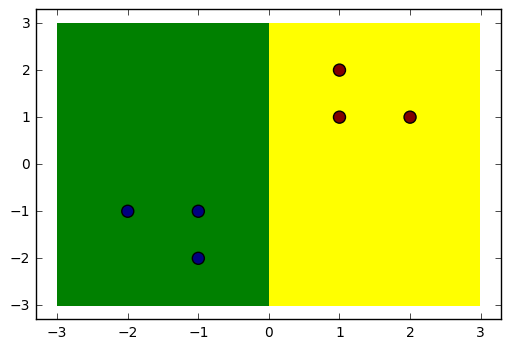

In [26]:
plot_on_plane(x, y)

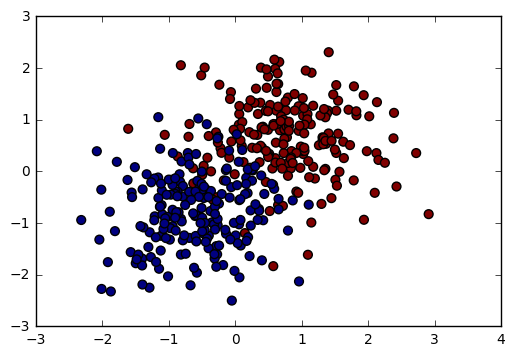

In [27]:
X = np.concatenate([np.random.normal(loc=0.7, scale=0.7, size=[200, 2]),
                    np.random.normal(loc=-0.7, scale=0.7, size=[200, 2])])
y = np.concatenate([np.ones(200),
                    np.zeros(200)])

plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
plt.show()

In [28]:
%%time
lm.fit(X, y)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 84 ms


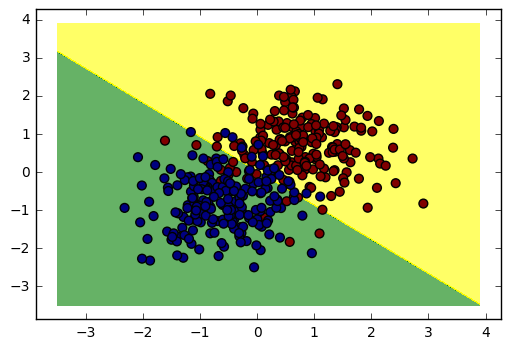

In [29]:
plot_on_plane(X, y, alpha=0.6, s=40)

In [30]:
sum(lm.predict(X)==y) / y.shape[0]

0.90000000000000002